# Introducción a Redes Neuronales Convolucionales (CNN)

Bienvenido a este tutorial introductorio de CNNs. En solo una hora, aprenderás los conceptos fundamentales de las Redes Neuronales Convolucionales y construirás tu primer clasificador de imágenes.

## ¿Qué aprenderás?

* **¿Qué es una CNN?** - Por qué son mejores que redes simples para imágenes
* **Componentes básicos** - Capas convolucionales, pooling y activación
* **Construcción práctica** - Crear tu primera CNN con PyTorch
* **Entrenamiento rápido** - Ver cómo aprende el modelo en tiempo real

¡Empecemos!

# Introducción a Redes Neuronales Convolucionales (CNN)

Bienvenido a este tutorial introductorio de CNNs. En solo una hora, aprenderás los conceptos fundamentales de las Redes Neuronales Convolucionales y construirás tu primer clasificador de imágenes.

## ¿Qué aprenderás?

* **¿Qué es una CNN?** - Por qué son mejores que redes simples para imágenes
* **Componentes básicos** - Capas convolucionales, pooling y activación
* **Construcción práctica** - Crear tu primera CNN con PyTorch
* **Entrenamiento rápido** - Ver cómo aprende el modelo en tiempo real

¡Empecemos!

## 1. Configuración Inicial

Importamos las bibliotecas necesarias y configuramos el dispositivo (CPU o GPU):

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Configurar dispositivo
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## 2. Preparar los Datos

Trabajaremos con un pequeño conjunto de imágenes de naturaleza (32x32 píxeles en color) con **6 clases**:

* **Flores**: 'orchid', 'sunflower'
* **Mamíferos**: 'fox', 'raccoon'
* **Insectos**: 'butterfly', 'beetle'

### Transformaciones

Las transformaciones preparan las imágenes para el entrenamiento:

In [6]:
# Media y desviación estándar para normalización
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Transformaciones para entrenamiento (con aumentación)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),              # Volteo aleatorio
    transforms.ToTensor(),                          # Convertir a tensor
    transforms.Normalize(cifar100_mean, cifar100_std)  # Normalizar
])

# Transformaciones para validación (sin aumentación)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

print("Transformaciones configuradas ✓")

Transformaciones configuradas ✓


### Cargar el Dataset

Usaremos solo 6 clases para este tutorial introductorio:

In [7]:
import torchvision.datasets as datasets

# Descargar CIFAR-100 (si no existe, lo descarga automáticamente) (https://www.cs.toronto.edu/~kriz/cifar.html)
print("Descargando CIFAR-100...")

train_dataset = datasets.CIFAR100(
    root='./cifar_100',
    train=True,
    download=True,
    transform=train_transform
)

val_dataset = datasets.CIFAR100(
    root='./cifar_100',
    train=False,
    download=True,
    transform=val_transform
)

print(f"✓ CIFAR-100 descargado: {len(train_dataset)} imágenes de entrenamiento")
print(f"✓ CIFAR-100 descargado: {len(val_dataset)} imágenes de validación")
print(f"✓ Total de clases disponibles: {len(train_dataset.classes)}")

Descargando CIFAR-100...
✓ CIFAR-100 descargado: 50000 imágenes de entrenamiento
✓ CIFAR-100 descargado: 10000 imágenes de validación
✓ Total de clases disponibles: 100


In [17]:
subset_target_classes = [
    'orchid', 'sunflower',      # Flores
    'fox', 'raccoon',            # Mamíferos
    'butterfly', 'beetle'        # Insectos
]

# Filtrar CIFAR-100 para las clases objetivo
target_indices_train = [train_dataset.class_to_idx[cls] for cls in subset_target_classes]
target_indices_val = [val_dataset.class_to_idx[cls] for cls in subset_target_classes]

# Filtrar los datos de entrenamiento
train_mask = [i for i, (_, label) in enumerate(train_dataset) if label in target_indices_train]
train_dataset.data = train_dataset.data[train_mask]
train_dataset.targets = [train_dataset.targets[i] for i in train_mask]

# Filtrar los datos de validación
val_mask = [i for i, (_, label) in enumerate(val_dataset) if label in target_indices_val]
val_dataset.data = val_dataset.data[val_mask]
val_dataset.targets = [val_dataset.targets[i] for i in val_mask]

print(f"✓ CIFAR-100 filtrado: {len(train_dataset)} imágenes de entrenamiento")
print(f"✓ CIFAR-100 filtrado: {len(val_dataset)} imágenes de validación")
print(f"✓ Clases seleccionadas: {subset_target_classes}")

✓ CIFAR-100 filtrado: 2500 imágenes de entrenamiento
✓ CIFAR-100 filtrado: 500 imágenes de validación
✓ Clases seleccionadas: ['orchid', 'sunflower', 'fox', 'raccoon', 'butterfly', 'beetle']


### Crear DataLoaders

Los DataLoaders nos permiten procesar los datos en lotes (batches):

In [18]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ DataLoaders creados con batch_size={batch_size}")

✓ DataLoaders creados con batch_size=64


### Visualizar las Imágenes

Veamos algunas imágenes de ejemplo:

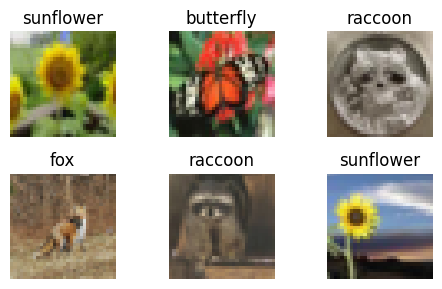

In [19]:
import numpy as np

import matplotlib.pyplot as plt

# Función para desnormalizar las imágenes
def denormalize(img, mean, std):
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return img * std + mean

# Visualizar imágenes
fig, axes = plt.subplots(2, 3, figsize=(5, 3))
axes = axes.flatten()

for i in range(6):
    img, label = train_dataset[i]
    img = denormalize(img.numpy(), cifar100_mean, cifar100_std)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
    
    axes[i].imshow(img)
    axes[i].set_title(train_dataset.classes[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 3. Construir la CNN

### ¿Qué es una CNN?

Una **CNN (Convolutional Neural Network)** es una red neuronal diseñada específicamente para procesar imágenes. A diferencia de las redes simples, las CNNs:

- **Preservan la estructura espacial** de la imagen
- **Detectan patrones locales** como bordes, texturas y formas
- **Son más eficientes** para imágenes

### Componentes Principales

**🔹 Capa Convolucional (`nn.Conv2d`)**
- Aplica filtros que detectan características (bordes, texturas, etc.)
- Produce "mapas de características" que resaltan patrones encontrados

**🔹 Función de Activación ReLU (`nn.ReLU`)**
- Introduce no-linealidad (convierte valores negativos a cero)
- Permite al modelo aprender patrones complejos

**🔹 Capa de Pooling (`nn.MaxPool2d`)**
- Reduce el tamaño de los mapas de características
- Mantiene la información más importante
- Hace el modelo más eficiente

**🔹 Capas Fully Connected (`nn.Linear`)**
- Al final de la red
- Combinan las características para hacer la predicción final

### Nuestra Arquitectura

Construiremos una CNN simple pero efectiva:

In [20]:
class SimpleCNN(nn.Module):
    """
    Una CNN simple para clasificación de imágenes.
    """
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Bloque 1: Detectar características básicas
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 canales RGB → 32 filtros
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # Reduce tamaño a la mitad (32x32 → 16x16)
        
        # Bloque 2: Características más complejas
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 → 64 filtros
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 → 8x8
        
        # Capas de clasificación
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Aplanar y reducir dimensiones
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)         # Prevenir sobreajuste
        self.fc2 = nn.Linear(128, num_classes) # Capa de salida

    def forward(self, x):
        # Flujo de datos a través de la red
        x = self.pool1(self.relu1(self.conv1(x)))  # Bloque 1
        x = self.pool2(self.relu2(self.conv2(x)))  # Bloque 2
        x = self.flatten(x)                         # Aplanar
        x = self.dropout(self.relu3(self.fc1(x))) # Clasificación
        x = self.fc2(x)                            # Salida
        return x

# Crear el modelo
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes)

print(f"✓ Modelo CNN creado para {num_classes} clases")
print(f"\n{model}")

✓ Modelo CNN creado para 100 clases

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=100, bias=True)
)


### Visualizar el Flujo de Datos

Veamos cómo cambia la forma de los datos al pasar por la red:

In [21]:
# Crear una imagen de ejemplo
x = torch.randn(1, 3, 32, 32)  # 1 imagen, 3 canales RGB, 32x32 píxeles

print("📊 Flujo de datos a través de la CNN:\n")
print(f"Entrada:          {x.shape}")

x = model.pool1(model.relu1(model.conv1(x)))
print(f"Después bloque 1: {x.shape}  (32 filtros, tamaño reducido)")

x = model.pool2(model.relu2(model.conv2(x)))
print(f"Después bloque 2: {x.shape}  (64 filtros, tamaño reducido)")

x = model.flatten(x)
print(f"Después flatten:  {x.shape}  (vector 1D)")

x = model.dropout(model.relu3(model.fc1(x)))
print(f"Después fc1:      {x.shape}  (características reducidas)")

x = model.fc2(x)
print(f"Salida:           {x.shape}  ({num_classes} clases)\n")

📊 Flujo de datos a través de la CNN:

Entrada:          torch.Size([1, 3, 32, 32])
Después bloque 1: torch.Size([1, 32, 16, 16])  (32 filtros, tamaño reducido)
Después bloque 2: torch.Size([1, 64, 8, 8])  (64 filtros, tamaño reducido)
Después flatten:  torch.Size([1, 4096])  (vector 1D)
Después fc1:      torch.Size([1, 128])  (características reducidas)
Salida:           torch.Size([1, 100])  (100 clases)



## 4. Entrenar el Modelo

### Configurar Entrenamiento

Necesitamos dos componentes clave:
- **Función de pérdida**: Mide qué tan equivocado está el modelo
- **Optimizador**: Ajusta los pesos del modelo para mejorar

In [22]:
# Función de pérdida (para clasificación multiclase)
loss_function = nn.CrossEntropyLoss()

# Optimizador (Adam es eficiente y popular)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✓ Función de pérdida y optimizador configurados")

✓ Función de pérdida y optimizador configurados


### Bucle de Entrenamiento Simplificado

Para esta sesión de 1 hora, usaremos una versión simplificada del bucle de entrenamiento:

In [23]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    """
    Función simplificada de entrenamiento
    """
    model.to(device)
    
    print("🚀 Iniciando entrenamiento...\n")
    
    for epoch in range(epochs):
        # === FASE DE ENTRENAMIENTO ===
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Paso hacia adelante
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Paso hacia atrás y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        
        # === FASE DE VALIDACIÓN ===
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        accuracy = 100.0 * correct / total
        
        # Imprimir progreso
        print(f"Época {epoch+1}/{epochs} | "
              f"Pérdida Entreno: {train_loss:.3f} | "
              f"Pérdida Valid: {val_loss:.3f} | "
              f"Precisión: {accuracy:.1f}%")
    
    print("\n✅ Entrenamiento completado!")
    return model

# Entrenar el modelo (solo 10 épocas para la sesión de 1 hora)
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_function,
    optimizer=optimizer,
    epochs=10,
    device=device
)

🚀 Iniciando entrenamiento...

Época 1/10 | Pérdida Entreno: 1.917 | Pérdida Valid: 1.027 | Precisión: 59.2%
Época 2/10 | Pérdida Entreno: 1.095 | Pérdida Valid: 0.858 | Precisión: 65.2%
Época 3/10 | Pérdida Entreno: 0.938 | Pérdida Valid: 0.809 | Precisión: 67.2%
Época 4/10 | Pérdida Entreno: 0.823 | Pérdida Valid: 0.721 | Precisión: 72.2%
Época 5/10 | Pérdida Entreno: 0.753 | Pérdida Valid: 0.638 | Precisión: 76.0%
Época 6/10 | Pérdida Entreno: 0.697 | Pérdida Valid: 0.645 | Precisión: 77.4%
Época 7/10 | Pérdida Entreno: 0.686 | Pérdida Valid: 0.611 | Precisión: 77.4%
Época 8/10 | Pérdida Entreno: 0.639 | Pérdida Valid: 0.576 | Precisión: 79.0%
Época 9/10 | Pérdida Entreno: 0.585 | Pérdida Valid: 0.550 | Precisión: 80.6%
Época 10/10 | Pérdida Entreno: 0.554 | Pérdida Valid: 0.531 | Precisión: 80.0%

✅ Entrenamiento completado!


## 5. Visualizar Resultados

Veamos cómo nuestro modelo hace predicciones en imágenes reales:

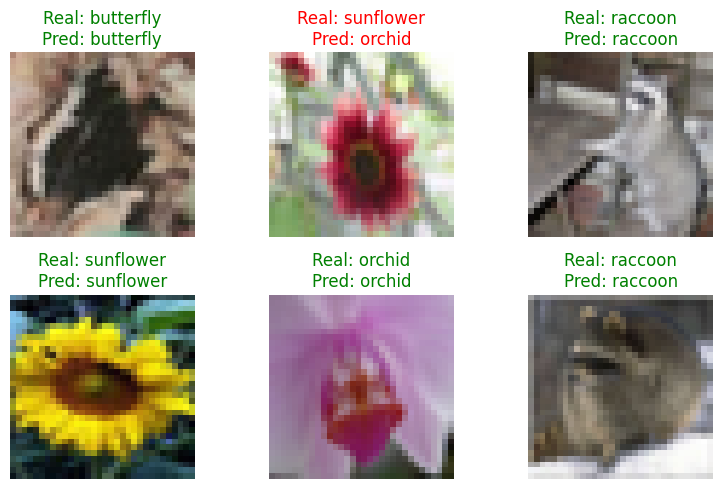

In [24]:
# Visualizar predicciones del modelo
# Obtener un batch de imágenes de validación
trained_model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Hacer predicciones
with torch.no_grad():
    outputs = trained_model(images)
    _, predicted = torch.max(outputs, 1)

# Visualizar las primeras 6 imágenes con sus predicciones
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()

for i in range(6):
    img = images[i].cpu().numpy()
    img = denormalize(img, cifar100_mean, cifar100_std)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    
    true_label = val_dataset.classes[labels[i].item()]
    pred_label = val_dataset.classes[predicted[i].item()]
    color = 'green' if labels[i] == predicted[i] else 'red'
    
    axes[i].imshow(img)
    axes[i].set_title(f'Real: {true_label}\nPred: {pred_label}', color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 6. Resumen y Conceptos Clave

### 🎯 ¿Qué aprendimos?

**1. Conceptos de CNN**
- Las CNNs son especiales para imágenes porque mantienen la estructura espacial
- Las capas convolucionales detectan patrones (bordes, texturas, formas)
- El pooling reduce dimensiones manteniendo información importante

**2. Componentes Principales**
```
Imagen → Conv2D → ReLU → MaxPool → Conv2D → ReLU → MaxPool → Flatten → Linear → Salida
```

**3. Pipeline Completa**
- Preparar datos (transformaciones y normalización)
- Construir arquitectura del modelo
- Entrenar (forward pass, calcular pérdida, backward pass, actualizar pesos)
- Evaluar